In [1]:
# cell 1 — setup imports and paths
import os
from pathlib import Path
import pandas as pd

from src.data_loader import load_raw, clean_weather, save_clean
from src.analysis import daily_stats, monthly_aggregation, seasonal_stats
from src.visualize import plot_daily_temp, plot_monthly_rainfall, plot_humidity_vs_temp

DATA_DIR = Path('data')
RAW = DATA_DIR / 'raw_weather.csv'
OUT_DIR = Path('outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)


In [2]:
# cell 2 — load dataset
df_raw = load_raw(RAW)
df_raw.head()


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [8]:
# cell 3 — clean dataset FOR AIR QUALITY DATASET
df = df_raw.copy()

# Fix date column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.set_index('Date').sort_index()

# Fill missing numeric values
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

df.head()


,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
Date,,,,,,,,,,,,,,,
2015-01-01,Ahmedabad,48.57,95.68,0.92,18.22,17.15,15.85,0.92,27.64,133.36,0.00,0.02,0.00,118.0,NaN
2015-01-01,Chennai,48.57,95.68,16.30,15.39,22.68,4.59,1.17,9.20,11.35,0.17,2.97,0.98,118.0,NaN
2015-01-01,Delhi,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe
2015-01-01,Lucknow,48.57,95.68,2.11,13.46,4.57,15.85,12.15,169.57,25.92,1.35,3.93,0.98,118.0,NaN
2015-01-01,Mumbai,48.57,95.68,9.89,21.69,27.38,15.85,0.00,9.16,30.84,0.00,0.00,0.00,118.0,NaN


In [4]:
# cell 4 — save cleaned dataframe
save_clean(df, OUT_DIR / 'cleaned_weather.csv')
df.head()


""
Date
2015-01-01
2015-01-01
2015-01-01
2015-01-01
2015-01-01


In [11]:
# cell 5 — AQI stats
print("Daily AQI Statistics:")
print(df['AQI'].describe())

print("\nMonthly Aggregation:")
monthly = df.resample('ME').agg({
    'PM2.5': 'mean',
    'PM10': 'mean',
    'AQI': 'mean'
})
monthly.head()


Daily AQI Statistics:
count    29531.000000
mean       158.781552
std        130.272413
min         13.000000
25%         88.000000
50%        118.000000
75%        179.000000
max       2049.000000
Name: AQI, dtype: float64

Monthly Aggregation:


,PM2.5,PM10,AQI
Date,,,
2015-01-31,67.622290,121.941822,153.747664
2015-02-28,72.233776,115.574235,199.346939
2015-03-31,73.978065,101.303502,190.230415
2015-04-30,64.247667,108.867333,177.733333
2015-05-31,60.904516,120.732949,182.092166


In [12]:
# cell 6 — seasonal AQI stats
df2 = df.copy()
df2['month'] = df2.index.month

def month_to_season(m):
    if m in [12,1,2]: return 'Winter'
    if m in [3,4,5]: return 'Summer'
    if m in [6,7,8]: return 'Monsoon'
    return 'Post-Monsoon'

df2['season'] = df2['month'].apply(month_to_season)

seasonal = df2.groupby('season')['AQI'].agg(['mean','min','max','std'])
seasonal


,mean,min,max,std
season,,,,
Monsoon,116.061682,16.0,1842.0,88.630635
Post-Monsoon,173.431972,13.0,1747.0,150.920078
Summer,143.355416,14.0,1459.0,108.177773
Winter,204.102016,26.0,2049.0,148.940639


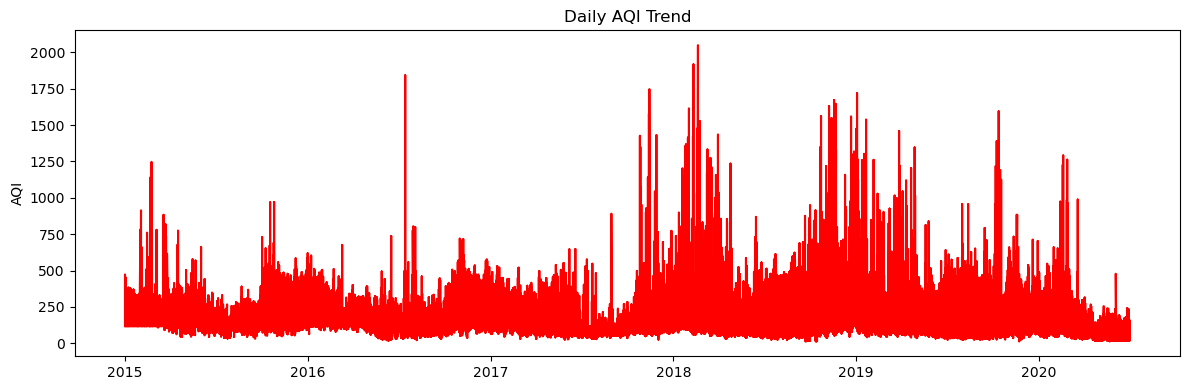

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df.index, df['AQI'], color='red')
plt.ylabel("AQI")
plt.title("Daily AQI Trend")
plt.tight_layout()
plt.savefig(OUT_DIR / 'aqi_daily_line.png')
plt.show()


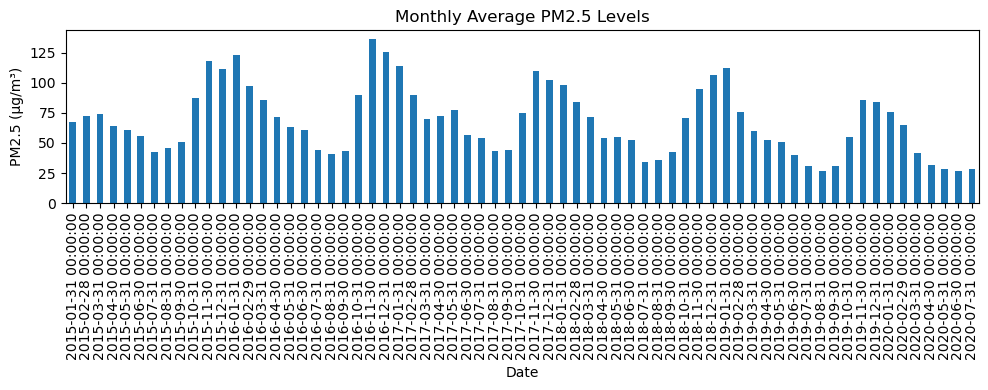

In [15]:
plt.figure(figsize=(10,4))
df.resample('ME')['PM2.5'].mean().plot(kind='bar')
plt.ylabel("PM2.5 (µg/m³)")
plt.title("Monthly Average PM2.5 Levels")
plt.tight_layout()
plt.savefig(OUT_DIR / 'pm25_monthly_bar.png')
plt.show()


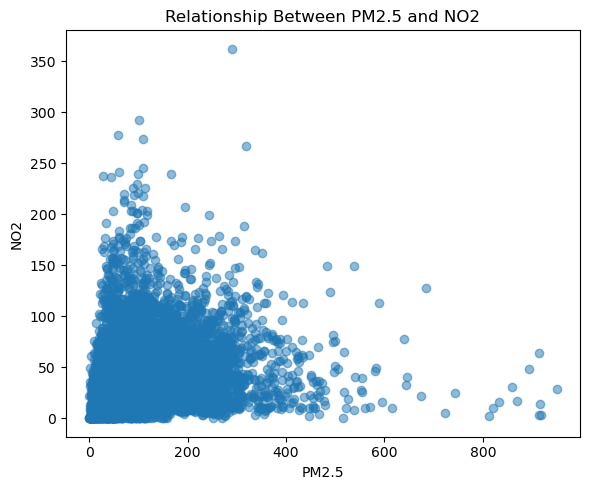

In [16]:
plt.figure(figsize=(6,5))
plt.scatter(df['PM2.5'], df['NO2'], alpha=0.5)
plt.xlabel("PM2.5")
plt.ylabel("NO2")
plt.title("Relationship Between PM2.5 and NO2")
plt.tight_layout()
plt.savefig(OUT_DIR / 'pm25_vs_no2_scatter.png')
plt.show()


In [17]:
monthly.to_csv(OUT_DIR / 'monthly_summary.csv')
